In [1]:
import numpy as np

from src.simulation.sim_core import simulation_core
from src.torch_geo.dataset.adaptive_speed2vec_dataset import adaptive_speed2vec_dataset
from src.generator.detector_node_connector import distance_connector_strategy
from src.simulation.modules.progress_module import progress_module
from src.simulation.modules.simulationFlowControlModule import simulationFlowControlModule
from src.torch_geo.model.trainer import model_train
from src.utils.math_utils import un_z_score

from torch_geometric.loader import DataLoader
from matplotlib import pyplot as plt
import torch, random, sumolib, libsumo

Create and set up settings

In [2]:
settings: dict = {
    # ----- framework settings -----
    "sumo_exec_path": "/home/howruck/Documents/GitHub/sumo/bin/sumo",
    "sumo_config_path": "/home/howruck/Documents/DeepSUMO/examples/celle_example_v1/config/osm.sumocfg",
    "sumo_net_path": "/home/howruck/Documents/DeepSUMO/examples/celle_example_v1/config/osm.net.xml.gz",

    # one day: 86400
    # one week: 604800
    # 777600
    # one month: 2419200
    "sim_length": 604800,  # total length of the simulation
    "interval_length": 300,  # size of one aggregation step

    # ----- model settings -----
    "N_HIST": 12,  # for Speed2Vec dataset, number of preceding steps
    "N_PRED": 9,  # for Speed2Vec dataset, number of prediction steps
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'DROPOUT': 0.6,
    'CHECKPOINT_DIR': './runs',

    'BATCH_SIZE': 50,
    'EPOCHS': 60,
    'N_NODE': 274
}
settings["total_graphs"] = int(settings["sim_length"]) // int(settings["interval_length"])

Create simulation core object and add observers

In [3]:
core = simulation_core(settings, distance_connector_strategy(50))

observer_1 = progress_module(settings["sim_length"] // 100)
observer_2 = simulationFlowControlModule(60)

core.add_continuous_observer(observer_1)
core.add_continuous_observer(observer_2)

Loading net-file from '/home/howruck/Documents/DeepSUMO/examples/celle_example_v1/config/osm.net.xml.gz' ... done (85ms).
Loading additional-files from '/home/howruck/Documents/DeepSUMO/examples/celle_example_v1/config/osm.poly.xml.gz' ... done (16ms).
Loading additional-files from '/home/howruck/Documents/DeepSUMO/examples/celle_example_v1/config/detectors_filtered.xml' ... done (12ms).
Loading done.
Simulation version 1.17.0 started via libsumo with time: 0.00.
[Translation Generator] - Generating dictionaries...
[Translation Controller] - Successfully initialized!
[Detector Graph Controller] - Generating graph, this can take a while...
[Detector Graph Controller] - Graph complete! Nodes: 274 Edges: 2338
[Numpy Graph Store] - Created node features: (2016, 274)
[Numpy Graph Store] - Created edge index: (2, 2338)
[Numpy Graph Store] - Successfully initialized!
[Numpy Graph Controller] - Initialized!
0


Start simulation

In [4]:
core.start_simulation()

-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 1
Flow between 0.1 and 0.2
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 2
Flow between 0.1 and 0.2
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 3
Flow between 0.1 and 0.2
----- 2 % -----
sim_step: 12097.0
last_sim_time: 0.6 seconds
scale: 0.17951866707815284
ETA: 0.98 minutes
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 4
Flow between 0.1 and 0.2
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 5
Flow between 0.1 and 0.2
----- 3 % -----
sim_step: 18145.0
last_sim_time: 0.57 seconds
scale: 0.16123333715743218
ETA: 0.95 minutes
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 6
Flow between 2.5 and 3.0
----- 4 % -----
sim_step: 24193.0
last_sim_time: 2.85 seconds
scale: 2.6718109438679023
ETA: 2.14 minutes
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 7
Flow between 2.5 and 3.0
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 8
Flow between 2.5 and 3.0
----- 5 %

Crate dataset from data collected by DeepSUMO

In [5]:
data = adaptive_speed2vec_dataset(core.get_data(), settings["total_graphs"])
data.process()

./processed/test_data.pt
torch.Size([2, 2338])
torch.int32


Split dataset into data loaders

(2015, 274)
121


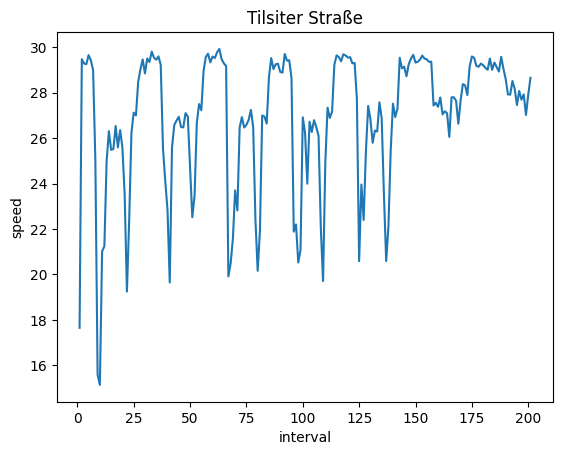

In [45]:
import numpy as np

l = []
l2 = []
buffer = []
s_id = random.randint(0, settings["N_NODE"] - 1)

print(core.get_data().numpy.get_speed_node_features().shape)
for i, point in enumerate(core.get_data().numpy.get_speed_node_features()):
    if i % 10 == 0:
        l2.append(np.average(buffer))
        buffer.clear()
    buffer.append(point[s_id] * 3.6)
    #print(point[12])
    l.append(point[s_id] * 3.6)

l = l[4:2000]

print(s_id)
sumo_id = core.get_data().translation.get_detector_id(s_id)
target_lane_id = libsumo.inductionloop.getLaneID(sumo_id)
target_lane: sumolib.net.lane.Lane = core.get_data().net.getLane(target_lane_id)
target_edge: sumolib.net.edge.Edge = target_lane.getEdge()

plt.title(target_edge.getName())
plt.plot(range(len(l2)), l2)
plt.xlabel("interval")
plt.ylabel("speed")
plt.show()

0, 268

In [46]:
train_threshold = int(len(data) * 0.9)
valid_threshold = int(len(data) * 0.9)
test_threshold = int(len(data) * 1.0)

train_loader = DataLoader(data[:train_threshold], shuffle=True, batch_size=settings["BATCH_SIZE"])
valid_loader = DataLoader(data[train_threshold:test_threshold], shuffle=True, batch_size=settings["BATCH_SIZE"])
test_loader = DataLoader(data[train_threshold:test_threshold], shuffle=False, batch_size=settings["BATCH_SIZE"])

Set up device

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cpu


Train the model

In [48]:
model = model_train(train_loader, valid_loader, settings, device)

Epoch 0: 100%|██████████| 36/36 [00:03<00:00,  9.51it/s]


36
Train, MAE: 1.2854341268539429, RMSE: 1.773581624031067, MAPE: 12.180684089660645
4
Valid, MAE: 1.0963470935821533, RMSE: 1.5959988832473755, MAPE: 9.773672103881836


Epoch 5: 100%|██████████| 36/36 [00:03<00:00,  9.59it/s]


36
Train, MAE: 0.7172106504440308, RMSE: 1.0293039083480835, MAPE: 6.683502197265625
4
Valid, MAE: 0.5867409110069275, RMSE: 0.8059620261192322, MAPE: 5.042450428009033


Epoch 10: 100%|██████████| 36/36 [00:03<00:00,  9.05it/s]


36
Train, MAE: 0.4746444523334503, RMSE: 0.7447863817214966, MAPE: 4.484166622161865
4
Valid, MAE: 0.4060949385166168, RMSE: 0.6395869851112366, MAPE: 3.7197325229644775


Epoch 15: 100%|██████████| 36/36 [00:04<00:00,  8.73it/s]


36
Train, MAE: 0.43754374980926514, RMSE: 0.6945807933807373, MAPE: 4.137613296508789
4
Valid, MAE: 0.39137524366378784, RMSE: 0.6153694987297058, MAPE: 3.5510311126708984


Epoch 20: 100%|██████████| 36/36 [00:03<00:00,  9.16it/s]


36
Train, MAE: 0.43082961440086365, RMSE: 0.6809386014938354, MAPE: 4.05086088180542
4
Valid, MAE: 0.3945840001106262, RMSE: 0.6060605049133301, MAPE: 3.523815155029297


Epoch 25: 100%|██████████| 36/36 [00:04<00:00,  8.67it/s]


36
Train, MAE: 0.42853865027427673, RMSE: 0.6739075183868408, MAPE: 4.01140022277832
4
Valid, MAE: 0.383584588766098, RMSE: 0.5966202020645142, MAPE: 3.448197364807129


Epoch 30: 100%|██████████| 36/36 [00:04<00:00,  8.60it/s]


36
Train, MAE: 0.4242199659347534, RMSE: 0.6679671406745911, MAPE: 3.9684863090515137
4
Valid, MAE: 0.38081076741218567, RMSE: 0.5895804762840271, MAPE: 3.390719413757324


Epoch 35: 100%|██████████| 36/36 [00:03<00:00,  9.08it/s]


36
Train, MAE: 0.4197494387626648, RMSE: 0.6641622185707092, MAPE: 3.9343714714050293
4
Valid, MAE: 0.3778713643550873, RMSE: 0.6011507511138916, MAPE: 3.418349027633667


Epoch 40: 100%|██████████| 36/36 [00:04<00:00,  8.50it/s]


36
Train, MAE: 0.4187792241573334, RMSE: 0.6599372029304504, MAPE: 3.913973808288574
4
Valid, MAE: 0.3808605670928955, RMSE: 0.5893182754516602, MAPE: 3.366056442260742


Epoch 45: 100%|██████████| 36/36 [00:03<00:00,  9.01it/s]


36
Train, MAE: 0.42098337411880493, RMSE: 0.6577571034431458, MAPE: 3.933547019958496
4
Valid, MAE: 0.38272178173065186, RMSE: 0.5884053111076355, MAPE: 3.391533851623535


Epoch 50: 100%|██████████| 36/36 [00:04<00:00,  8.74it/s]


36
Train, MAE: 0.4242058992385864, RMSE: 0.6563131809234619, MAPE: 3.9303159713745117
4
Valid, MAE: 0.39000895619392395, RMSE: 0.5957309007644653, MAPE: 3.421630859375


Epoch 55: 100%|██████████| 36/36 [00:04<00:00,  8.65it/s]


36
Train, MAE: 0.418521910905838, RMSE: 0.6474207043647766, MAPE: 3.8803024291992188
4
Valid, MAE: 0.3843444585800171, RMSE: 0.5911877155303955, MAPE: 3.407050132751465


Epoch 59: 100%|██████████| 36/36 [00:04<00:00,  8.93it/s]


Get predictions on testing dataset and organize them in a way, so that they can be easily plotted

In [50]:
model.eval()
model.to(device)

for i, batch in enumerate(test_loader):
    # get predictions from model
    batch = batch.to(device)
    with torch.no_grad():
        pred = model(batch, device)

    truth = batch.y.view(pred.shape)
    # all values have been normalized using the z-score method,
    # so they have to be unnormalized again for evaluation
    truth = un_z_score(truth, test_loader.dataset.mean,
                       test_loader.dataset.std_dev)
    pred = un_z_score(pred, test_loader.dataset.mean,
                      test_loader.dataset.std_dev)

    truth = batch.y.view(pred.shape)
    if i == 0:
        y_pred = torch.zeros(len(test_loader), pred.shape[0], pred.shape[1])
        y_truth = torch.zeros(len(test_loader), pred.shape[0], pred.shape[1])
    y_pred[i, :pred.shape[0], :] = pred
    y_truth[i, :pred.shape[0], :] = truth

y_pred = y_pred.reshape(len(test_loader) * settings['BATCH_SIZE'],
                        settings["N_NODE"], 9)
y_truth = y_truth.reshape(len(test_loader) * settings['BATCH_SIZE'],
                          settings["N_NODE"], 9)

y_truth = un_z_score(y_truth, data.mean, data.std_dev)

Plot predictions and truth of a random detector

334


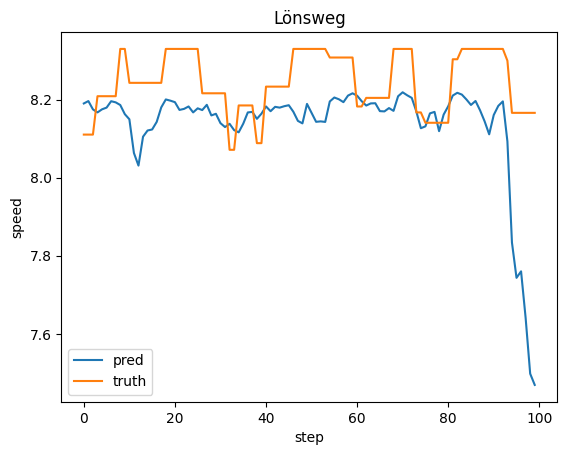

In [78]:


s1 = []
s2 = []
# get a random node
target = random.randint(0, settings["N_NODE"] - 1)
#print(core._data.translation.get_order())
#target = core._data.translation.get_index("98")

# get name of street associated with chosen detector
sumo_id = core.get_data().translation.get_detector_id(target)
target_lane_id = libsumo.inductionloop.getLaneID(sumo_id)
target_lane: sumolib.net.lane.Lane = core.get_data().net.getLane(target_lane_id)
target_edge: sumolib.net.edge.Edge = target_lane.getEdge()

for i in range(100):
    s1.append(y_pred[i][target][0])
    s2.append(y_truth[i][target][0])

print(sumo_id)
#print(y_pred[:][target])
#print(y_truth[:][target])

plt.title(target_edge.getName())
plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(100), s1, label='pred')
plt.plot(range(100), s2, label='truth')
plt.xlabel("step")
plt.ylabel("speed")
plt.legend()
plt.show()